<a href="https://colab.research.google.com/github/licTomasPerez/Spin-Chains-/blob/main/Optimized_corr_xop_v_pop_H_SpinChain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install matplotlib
!pip install qutip
!pip install numpy
!pip install scipy.optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement scipy.optimize (from versions: none)
ERROR: No matching distribution found for scipy.optimize


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math
import cmath 
from qutip import *

In [ ]:
### XYZ Heisenberg model
N=5

solver = "me"   
id2 = qeye(2)
sx = .5*sigmax()
sy = .5*sigmay()
sz = .5*sigmaz()

sx_list = []
sy_list = []
sz_list = []

for n in range(N):
    operator_list = []
    for m in range(N):
        operator_list.append(id2)
    operator_list[n] = sx
    sx_list.append(tensor(operator_list))
        
    operator_list[n] = sy
    sy_list.append(tensor(operator_list))
        
    operator_list[n] = sz
    sz_list.append(tensor(operator_list))

sxsx_list = [sx_list[n]*sx_list[m] for n in range(N) for m in range(N)]
sysy_list = [sy_list[n]*sy_list[m] for n in range(N) for m in range(N)]

In [ ]:
def Heisenberg_hamiltonian (N, Jx, Jy, Jz, h):
  H = 0
  for n in range(N):
    H += -0.5*h[n]*sz_list[n]
        
  for n in range(N-1):
    H += -0.5 * Jx[n] * sx_list[n] * sx_list[n+1]
    H += -0.5 * Jy[n] * sy_list[n] * sy_list[n+1]
    H += -0.5 * Jz[n] * sz_list[n] * sz_list[n+1]
  return H

N = 5            # número de spines

h  = 1.0 * 2 * np.pi * np.ones(N) 
Jx = 0.15 * 2 * np.pi * np.ones(N)
Jy = 0.25 * 2 * np.pi * np.ones(N)
Jz = 0.1 * 2 * np.pi * np.ones(N)

In [ ]:
def logM(rho):
  vals, vecs = rho.eigenstates() 
  return sum([np.log(val)*vec*vec.dag() for val,vec in zip(vals, vecs) if val>0])

def rel_entropy(rho, sigma):
    val = (rho*(logM(rho)-logM(sigma))).tr()
    if abs(val.imag)>1.e-6:
        print("rho or sigma not positive")
        print(rho.eigenstates())
        print(sigma.eigenstates())
    return val.real

In [ ]:
# dephasing rate
gamma = 5 * 10**-1* np.ones(N)

# intial state, first spin in state |1>, the rest in state |0>
psi_list = []
for n in range(2):
    psi_list.append(basis(2,0))
psi_list.append(basis(2,1))
for n in range(2):
    psi_list.append(basis(2,0))
psi0 = tensor(psi_list)

tlist = np.linspace(0, 10, 1000)

psiT_list = []

psiT_list.append(basis(2,0))
for n in range(4):
  psiT_list.append(basis(2,1))

psiT = tensor(psiT_list)


In [ ]:
def hamiltonian_integration(N, Jx, Jy, Jz, h, psi_0, tlist, gamma=1e-10, solver="me"):
    H_H = Heisenberg_hamiltonian(N, Jx, Jy, Jz, h)

    x_op = sum((.5 - sz_list[i])*i for i in range(N))
    p_op = 1j*(x_op*H_H-H_H*x_op)
    corr_op = .5*(x_op*p_op+p_op*x_op)
    comm_op = -1j*(x_op*p_op-p_op*x_op)
    p_dot = 1j*(H_H * p_op - p_op * H_H)

    # collapse operators
    c_op_list = []

    # spin dephasing
    for n in range(N):
        if gamma[n] > 0.0:
            c_op_list.append(np.sqrt(gamma[n]) * sz_list[n])

    obs = [x_op, p_op, x_op**2,p_op**2, corr_op, p_dot]
       
    if solver == "me":
        result_spin_ops = mesolve(H_H, psi0, tlist, c_op_list)
    elif solver == "mc":
        ntraj = 200 
        result_spin_ops = mcsolve(H_H, psi0, tlist, c_op_list, obs)

    return result_spin_ops.states

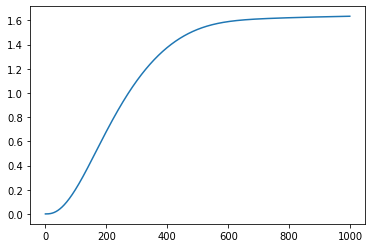

In [ ]:
results = hamiltonian_integration(N, Jx, Jy, Jz, h, psi0, tlist, gamma, solver)

entropy = []
for t in range(len(tlist)): 
  entropy.append(entropy_vn(results[t]))

plt.plot(entropy)

In [1]:
def hamiltonian_integration(N, Jx, Jy, Jz, h, psi_0, tlist, gamma=1e-10, solver="me"):
    H_H = Heisenberg_hamiltonian(N, Jx, Jy, Jz, h)

    x_op = sum((.5 - sz_list[i])*i for i in range(N))
    p_op = 1j*(x_op*H_H-H_H*x_op)
    corr_op = .5*(x_op*p_op+p_op*x_op)
    comm_op = -1j*(x_op*p_op-p_op*x_op)
    p_dot = 1j*(H_H * p_op - p_op * H_H)

    entropyVN = []
    def callback_entropy(t, rhot):
        entropyVN.append(entropy_vn(rhot))

    # collapse operators
    c_op_list = []

    # spin dephasing
    for n in range(N):
        if gamma[n] > 0.0:
            c_op_list.append(np.sqrt(gamma[n]) * sz_list[n])

    obs = [x_op, p_op, x_op**2,p_op**2, corr_op, p_dot]
       
    if solver == "me":
        result_spin_ops = mesolve(H_H, psi0, tlist, c_op_list, callback_entropy)
    elif solver == "mc":
        ntraj = 200 
        result_spin_ops = mcsolve(H_H, psi0, tlist, c_op_list, obs)

    # return result_spin_ops.expect
    return entropyVN


In [ ]:
results = hamiltonian_integration(N, Jx, Jy, Jz, h, psi0, tlist, gamma, solver)

plt.plot(results)

TypeError: ignored

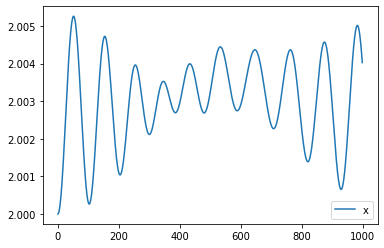

In [ ]:
results = hamiltonian_integration(N, Jx, Jy, Jz, h, psi0, tlist, gamma, solver)

plt.plot(results[0],label="x")
#plt.plot(-1*results[1],label="$\dot{x}=p=[H_H,x]$")
#plt.plot(results[2]-results[0]**2,label="dx^2")
#plt.plot(results[3]-results[1]**2,label="dp^2")
#plt.plot(-6*(results[4]-results[0]*results[1]),label="x p ")
#plt.plot(results[5],label="$\dot{p}= i[H_H,p]$")
#plt.plot(results[3],label="comm")
plt.legend()

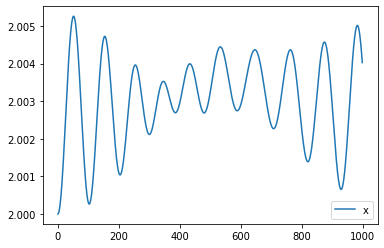

In [ ]:
results = hamiltonian_integration(N, Jx, Jy, Jz, h, psiT, tlist, gamma, solver)

plt.plot(results[0],label="x")
#plt.plot(-1*results[1],label="$\dot{x}=p=[H_H,x]$")
#plt.plot(results[2]-results[0]**2,label="dx^2")
#plt.plot(results[3]-results[1]**2,label="dp^2")
#plt.plot(-6*(results[4]-results[0]*results[1]),label="x p ")
#plt.plot(results[5],label="$\dot{p}= i[H_H,p]$")
#plt.plot(results[3],label="comm")
plt.legend()

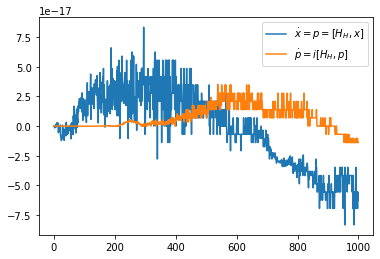

In [ ]:
results = hamiltonian_integration(N, Jx, Jy, Jz, h, psi0, tlist, gamma, solver)

#plt.plot(results[0],label="x")
plt.plot(-1*results[1],label="$\dot{x}=p=[H_H,x]$")
#plt.plot(results[2]-results[0]**2,label="dx^2")
#plt.plot(results[3]-results[1]**2,label="dp^2")
#plt.plot(-6*(results[4]-results[0]*results[1]),label="x p ")
plt.plot(results[5],label="$\dot{p}= i[H_H,p]$")
#plt.plot(results[3],label="comm")
plt.legend()

Here we are interested in computing the following expression

$$
\mu_X = \frac{\bigg(\sum_{i=1}^N\langle s_z^i \rangle+ \frac{1}{2}\bigg)i}{\sum_{i=1}^N\langle s_z^i \rangle+ \frac{1}{2}}
$$

and the standard deviation is 


$$
\sigma^2_X= \frac{\bigg(\sum_{i=1}^N\langle s_{z}^{i} \rangle+ \frac{1}{2}\bigg)i^2}{\sum_{i=1}^N\langle s_z^i \rangle+ \frac{1}{2}} - \bigg[\frac  {\bigg(\sum_{i=1}^N\langle s_{z}^{i} \rangle+ \frac{1}{2}\bigg)i}{\sum_{i=1}^N\langle s_z^i \rangle+ \frac{1}{2}}\bigg]^2
$$

In [ ]:
def hamiltonian_integration(N, Jx, Jy, Jz, h, psi_0, tlist, gamma=1e-10, solver="me"):
    H_H = Heisenberg_hamiltonian(N, Jx, Jy, Jz, h)

    x_op = sum((.5 - sz_list[i])*i for i in range(N))
    p_op = 1j*(x_op*H_H-H_H*x_op)
    corr_op = .5*(x_op*p_op+p_op*x_op)
    comm_op = -1j*(x_op*p_op-p_op*x_op)

    # collapse operators
    c_op_list = []

    # spin dephasing
    for n in range(N):
        if gamma[n] > 0.0:
            c_op_list.append(np.sqrt(gamma[n]) * sz_list[n])
   
    if solver == "me":
        result_spin_ops = mesolve(H_H, psi0, tlist, c_op_list, sz_list)
    elif solver == "mc":
        ntraj = 200 
        result_spin_ops = mcsolve(H_H, psi0, tlist, c_op_list, sz_list)

    return result_spin_ops.expect

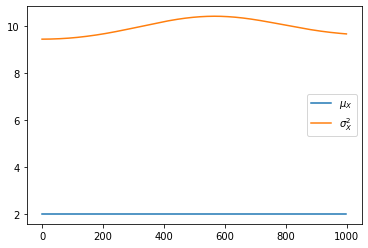

In [ ]:
sz_expt = hamiltonian_integration(N, Jx, Jy, Jz, h, psi0, tlist, gamma, solver)

denom_muX = sum(.5*(1-sz_expt[i]) for i in range(5))
mu_X= sum(.5*(1-sz_expt[i])*i for i in range((5)))/denom_muX
std_devX_term1 = sum(.5*(1-sz_expt[i])*i**2 for i in range((5)))/denom_muX
std_devX_term2 = mu_X**2

std_devX = std_devX_term1 + std_devX_term2

plt.plot(mu_X, label=r"$\mu_X$")
plt.plot(std_devX, label=r"$\sigma_X^2$")
plt.legend()

In [ ]:
psiT_list = []

psiT_list.append(basis(2,0))
for n in range(4):
  psiT_list.append(basis(2,1))

psiT = tensor(psiT_list)
print(psiT)

Quantum object: dims = [[2, 2, 2, 2, 2], [1, 1, 1, 1, 1]], shape = (32, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


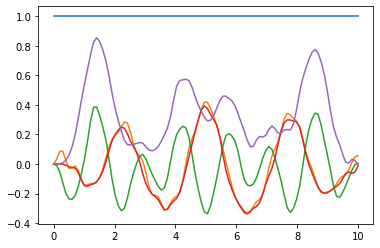

In [ ]:
#sigma_x sigmax evolucionado 
fig, ax = plt.subplots()

for n in range(N):
    ax.plot(tlist, np.real(sxsx_results[n]))

plt.show()


In [ ]:
# dephasing rate
gamma = 5 * 10**-10* np.ones(N)

# intial state, first spin in state |1>, the rest in state |0>
psi_list = []
for n in range(2):
    psi_list.append(basis(2,0))
psi_list.append(basis(2,1))
for n in range(2):
    psi_list.append(basis(2,0))
psi0 = tensor(psi_list)

tlist = np.linspace(0, 10, 100)

results = hamiltonian(N, Jx, Jy, Jz, h, psi0, tlist, gamma, solver)

#sxsx_results = results.expect[0]
sysy_results = results
#sz_results = results

/usr/local/lib/python3.7/dist-packages/matplotlib/collections.py:153: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


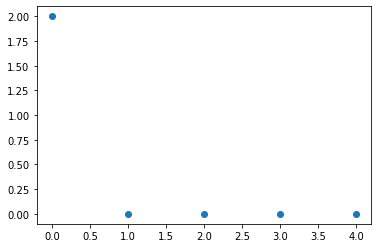

In [ ]:
def W(a, N): 
  return sum(np.exp(1j * k * 2 * np.pi * (a) * N**-1)*(2) for k in range(N))/N

plt.scatter([a for a in range(5)],[W(a, 5) for a in range(5)])

In [ ]:
x_op = sum((.5 + sz_expt[i])*i for i in range(N))

def W(a,b, k_max): 
  return sum(e**(1j * k * 2 * pi * (a-b) * N**-1)*(k*2*pi*N**-1) for k in range(k_max))

p_op = np.real(sum(W(i,j,10)*(sx_expt[i]*sx_expt[j]+sy_expt[i]*sy_expt[j]) for i in range(N) for j in range(N)))

corr_xop_pop = .5*(x_op * p_op + p_op * x_op)


In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

ax.plot(tlist, x_op-10.95, label=r'$\hat{x}= \langle \sum_{a}(\sigma_z^{(a)}+1/2)*a\rangle - 10.95$')
ax.plot(tlist, p_op, label=r'$\hat{p}= \langle \sum_{a,b}W(a,b,k_{max})(\sigma_x^{(a)}\sigma_x^{(b)}+\sigma_y^{(a)}\sigma_y^{(b)}}))\rangle$')

ax.legend(loc=0)
ax.set_xlabel(r'Time [s]')
ax.set_ylabel(r'$\langle\sigma_z\rangle$')
ax.set_title(r'Dynamics of a Heisenberg spin chain for N=5 spins and $\gamma = 5\times 10^{-10} $');

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

for n in range(N):
    ax.plot(tlist, np.real(sz_expt[n]), label=r'$\langle\sigma_z^{(%d)}\rangle$'%n)

ax.legend(loc=0)
ax.set_xlabel(r'Time [s]')
ax.set_ylabel(r'$\langle\sigma_z\rangle$')
ax.set_title(r'Dynamics of a Heisenberg spin chain for N=5 spins and $\gamma = 5\times 10^{-10} $');